# Building a DNN on MNIST Dataset

In [142]:
import tensorflow as tf
from tensorflow import keras 
from sklearn.metrics import precision_score
from sklearn.preprocessing import Normalizer

In [143]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [144]:
X_train, y_train, X_valid, y_valid = X_train_full[:50000], y_train_full[:50000], X_train_full[50000:], y_train_full[50000:]

Function to rescale data between 0 and 1. Also reshapes input from (28, 28) to a single stream of 784 

In [145]:
norm = Normalizer(norm='max')
def app_norm(data):
    nsamples, x, y = data.shape
    data_2d = data.reshape((nsamples, x*y))
    return norm.fit_transform(data_2d)
X_train, X_valid, X_test = app_norm(X_train), app_norm(X_valid), app_norm(X_test)

In [146]:
model = keras.models.Sequential([
    keras.layers.Dense(100, input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [147]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 100)               78500     
                                                                 
 dense_36 (Dense)            (None, 100)               10100     
                                                                 
 dense_37 (Dense)            (None, 100)               10100     
                                                                 
 dense_38 (Dense)            (None, 10)                1010      
                                                                 
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy']
)

In [149]:
early_stopping_callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [150]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.98):
            print("98% accuracy reached in training, cancelling training.")
            self.model.stop_training = True

callback = Callback()

In [151]:
history = model.fit(
    X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_callback, callback]
)

Epoch 1/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6526 - accuracy: 0.8205 - val_loss: 0.3050 - val_accuracy: 0.9140
Epoch 2/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3012 - accuracy: 0.9116 - val_loss: 0.2474 - val_accuracy: 0.9282
Epoch 3/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2477 - accuracy: 0.9284 - val_loss: 0.2145 - val_accuracy: 0.9408
Epoch 4/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2145 - accuracy: 0.9367 - val_loss: 0.1916 - val_accuracy: 0.9454
Epoch 5/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1903 - accuracy: 0.9436 - val_loss: 0.1803 - val_accuracy: 0.9490
Epoch 6/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1715 - accuracy: 0.9489 - val_loss: 0.1628 - val_accuracy: 0.9527
Epoch 7/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1562 - accuracy: 0.9538 - val_loss: 0.1520 - val_accuracy:

In [152]:
model.save('models/MNIST_model.h5')

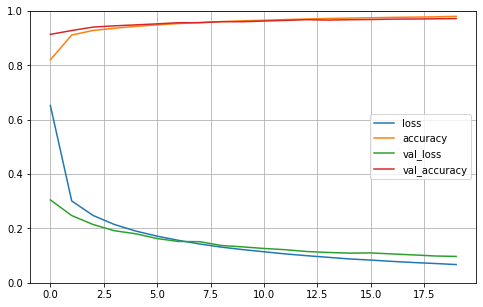

In [153]:
import pandas as pd 
import matplotlib.pyplot as plt 

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [156]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9705


[0.0982302874326706, 0.9704999923706055]

In [155]:
y_pred = model.predict(X_test)